# Мандат и Функции на Българската народна банка
Данните, които използваме в това изследване, съдържат документи, свързани с БНБ, предварително разпределени в седем категории, обхващати основните функции на централната банка за периода, към която съответният закон реферира: устройствени закони и устави на БНБ, търговскобанкова функция, емисионна фунцкия, функция по провеждане на паричната политика, функция на фискален агент, регулаторна и надзорна фунцкия и други\footnote{Последните две в текущия анализ са обединени в обща категория ''регулаторна'', поради малкия брой закони, които са свързани със съответните функции.}. Извличането на съществена информация от текст изисква предварителна обработка на данните, която и ние прилагаме върху документите (законите и уставите):

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from nltk import bigrams
import itertools
import collections
import networkx as nx
import nltk
import re

In [2]:
db = pd.read_pickle('dflaws.pkl')
db.head()

,Unnamed: 0,Year,Issue,Law,Text,Period,Function,Ruler
0,0,1879,0,1,проект устав бълг народн банк утвърд руск импе...,1,Устройствени закони и устави,Княз Корсаков
1,1,1879,0,1,инструкци дейност бълг народн банк нейн отдел ...,1,Устройствени закони и устави,Княз Корсаков
2,2,1879,0,1,приложени формуляр достоверени необходим цел и...,1,Устройствени закони и устави,Княз Александър I
3,3,1883,0,2,изда двор софи юлий александр приподпи минист ...,1,Устройствени закони и устави,0
4,4,1883,29,3,резулт надзор състав особ глав рапорт представ...,1,Устройствени закони и устави,Княз Александър I


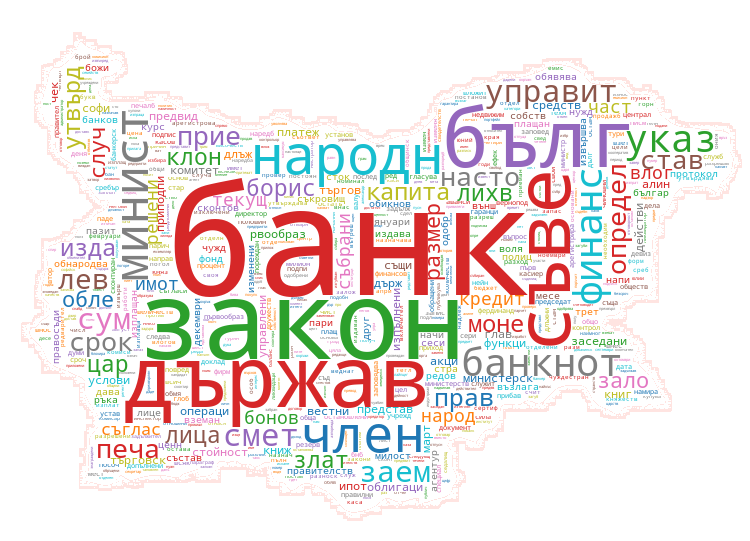

In [3]:
#join the text from all the documents into one long string
onestring = ','.join(list(db['Text']))
# Create a WordCloud object
bgmask = np.array(Image.open("bg.png"))
wordcloud = WordCloud(background_color="white", max_words=10000, 
                      mask = bgmask, contour_width=1, contour_color='mistyrose',
                      collocations = False, colormap='tab10')
# Generate a word cloud
wordcloud.generate(onestring)
# Visualize the word cloud
wordcloud.to_image()

In [4]:
bnbfunctions = db['Function'].unique()

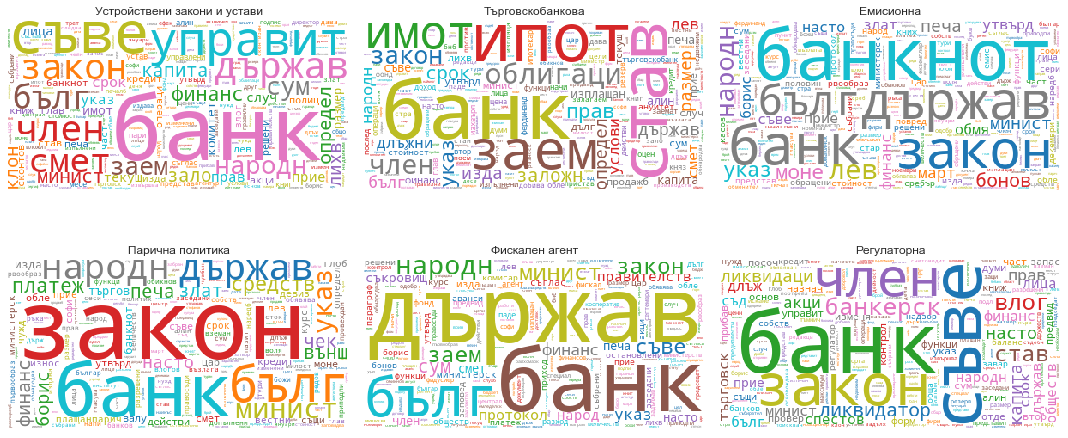

In [5]:
sns.set()
wordcloud = WordCloud(background_color="white", max_words=5000,
                      collocations = False, colormap='tab10')
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))
for i in range(0, len(bnbfunctions)):
    dbf = db[db['Function']==bnbfunctions[i]]
    onestring = ','.join(list(dbf['Text']))
    wordcloud.generate(onestring)
    axes[int(i/3), i%3].imshow(wordcloud)
    axes[int(i/3), i%3].axis('off')
    axes[int(i/3), i%3].set_title(bnbfunctions[i])
    axes[int(i/3), i%3].set_xticklabels([])
    axes[int(i/3), i%3].set_yticklabels([])
    
plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

In [6]:
words = nltk.word_tokenize(''.join(str(db['Text'].tolist())).replace('\'',""))
bigramdf = pd.DataFrame(pd.Series(nltk.ngrams(words, 2)).value_counts(), columns=['count'])
bigramdf['bigram'] = bigramdf.index
bigramdf = bigramdf.reset_index()
bigramdf = bigramdf.drop('index', axis=1)
bigramdf  = bigramdf.iloc[:150, :]

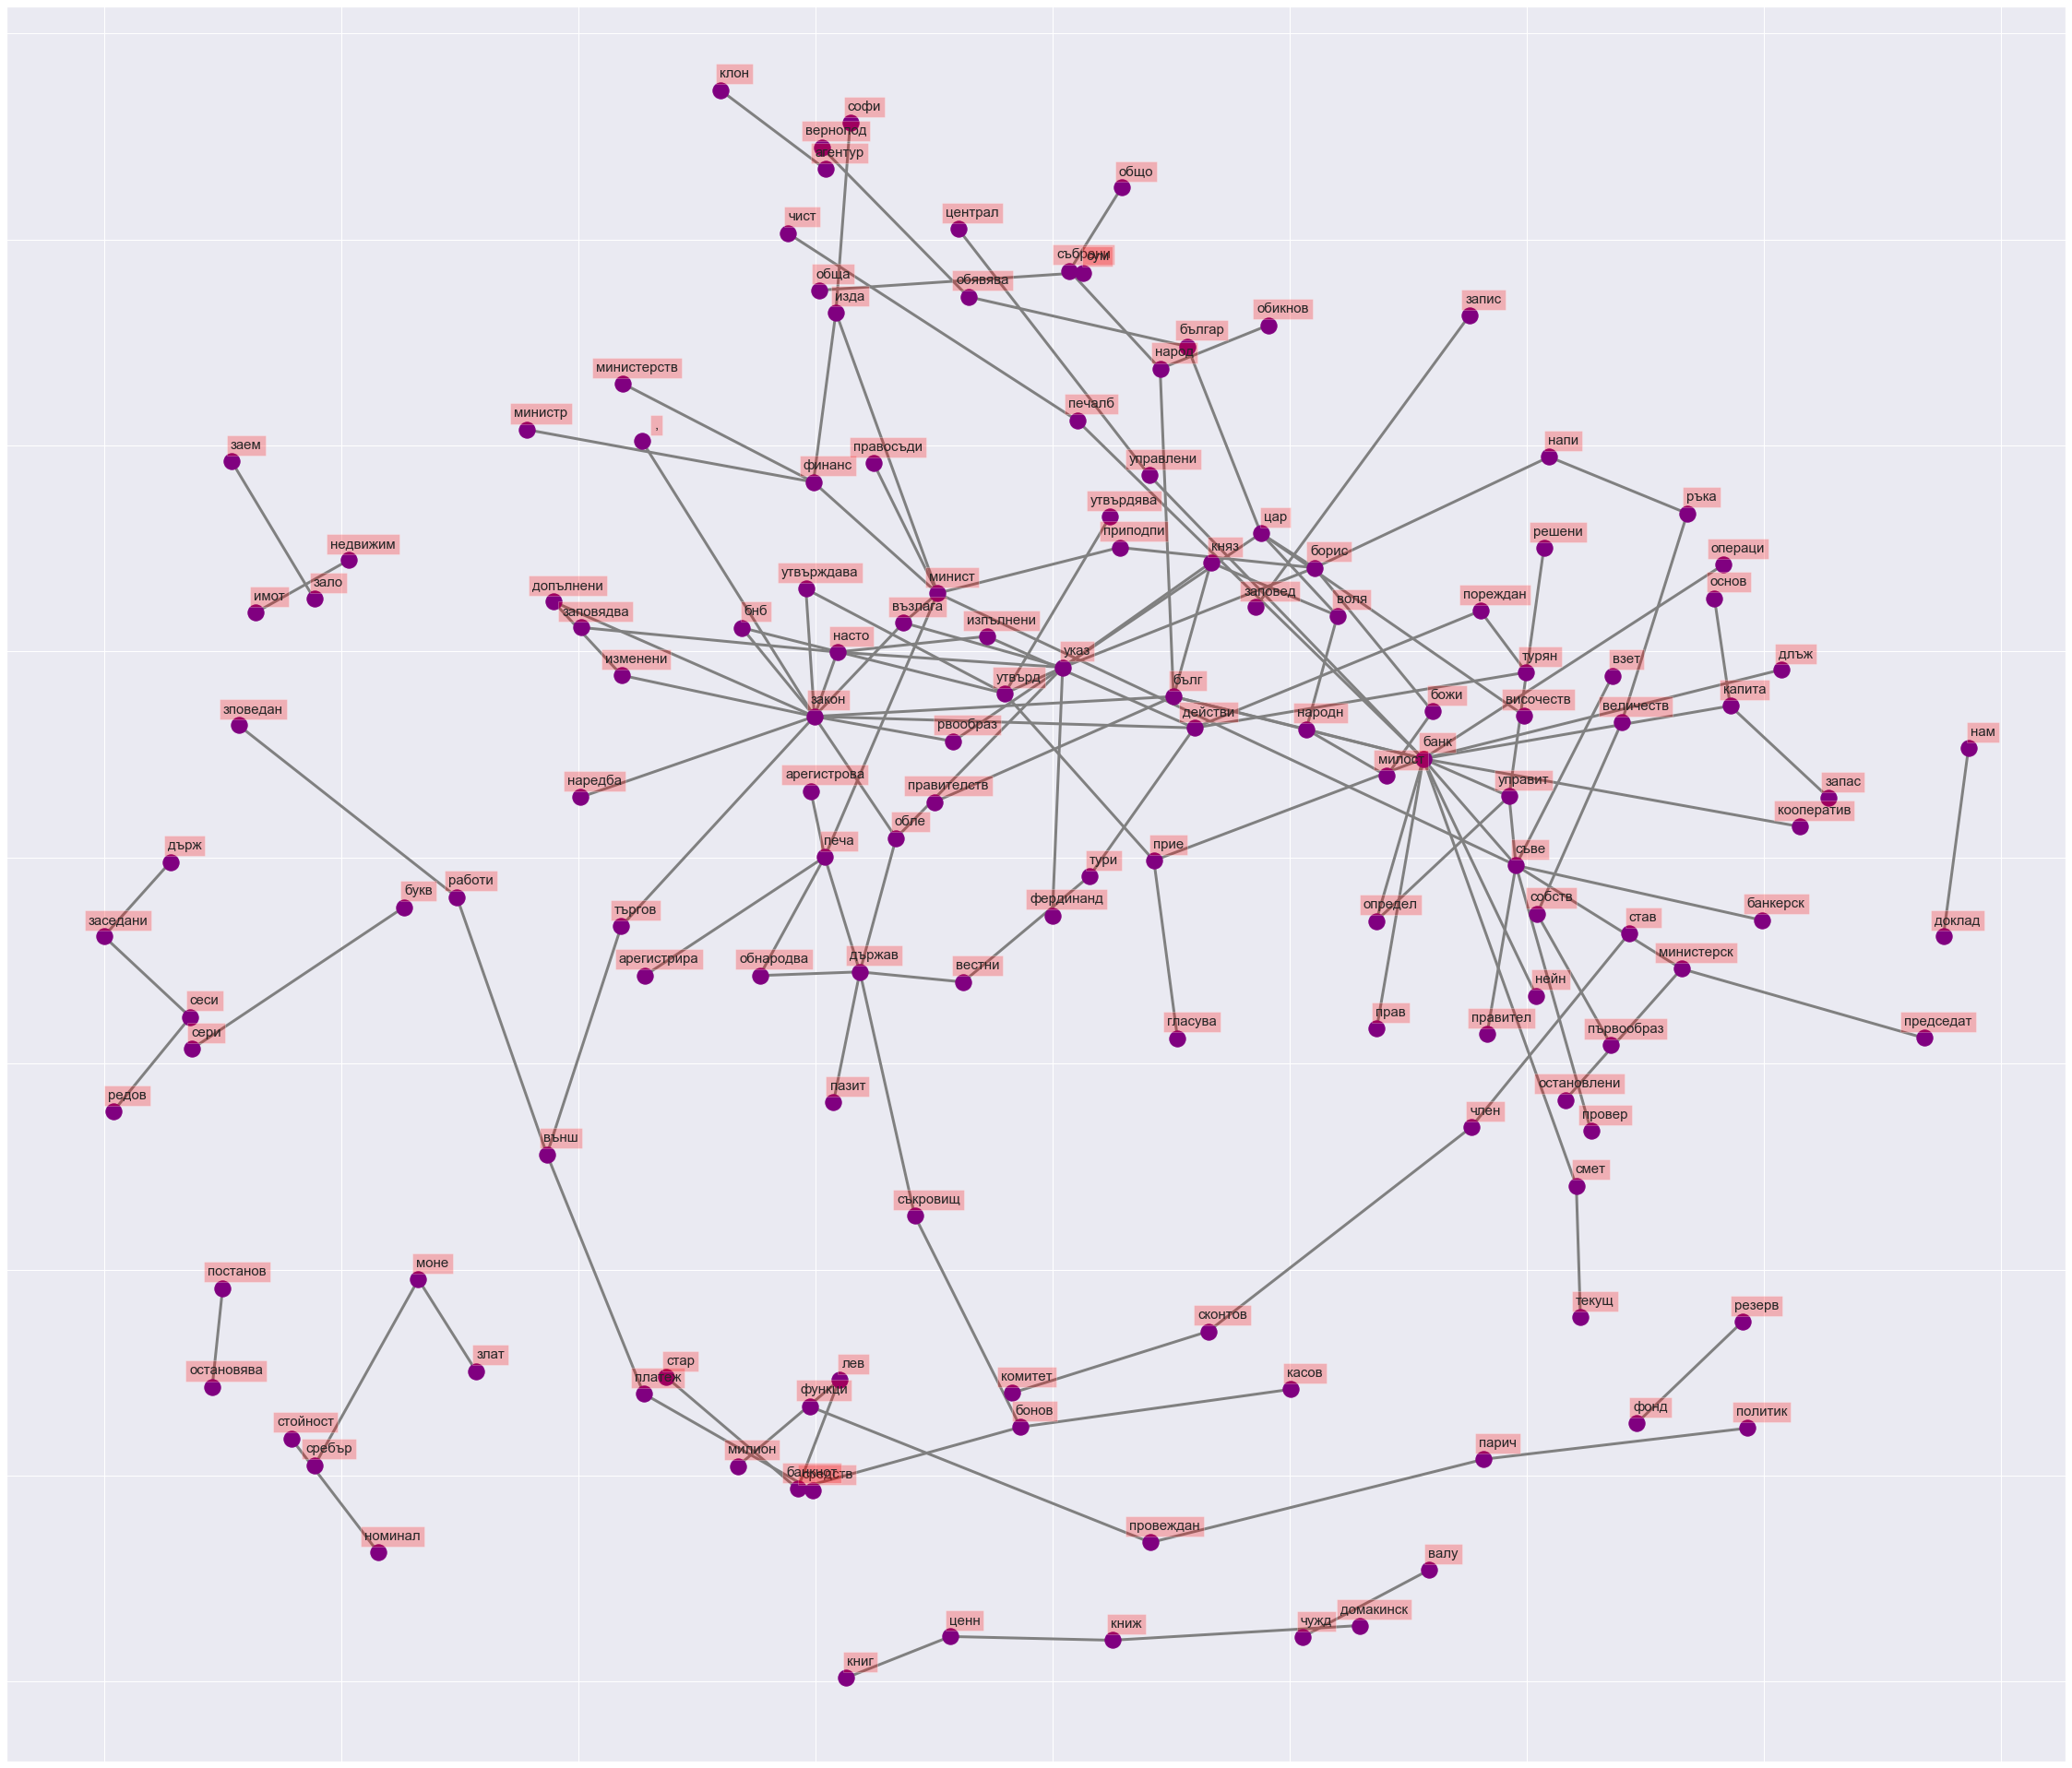

In [7]:
# Create dictionary of bigrams and their counts
d = bigramdf.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(40, 35))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.015, value[1]+.015
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=15)
    
plt.show()


In [8]:
countsr = db.groupby(['Year', 'Function', 'Ruler'], as_index=False)['Text'].count()

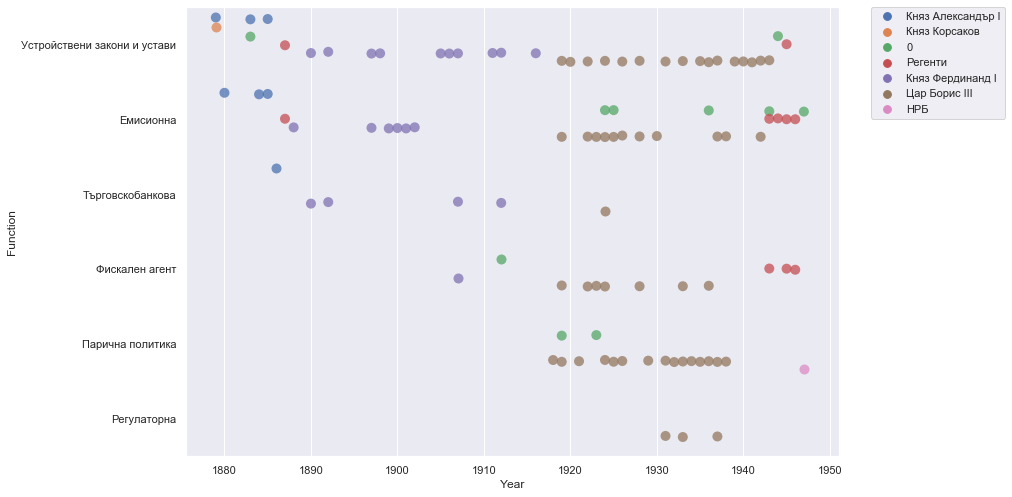

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.stripplot(x='Year', y="Function", hue="Ruler",
              data=countsr, dodge=True, alpha=.75, size = 10, zorder=1);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [10]:
countsr = db.groupby(['Function'], as_index=False)['Text'].agg({'Text': ' '.join})
countsr.head()

,Function,Text
0,Емисионна,емисион функци закон прав рязане моне бълг утв...
1,Парична политика,остан член прие управит съве бълг народн банк ...
2,Регулаторна,регулатор надзор функци основаван банк открива...
3,Търговскобанкова,търговскобанк функци закон издаван бнб облигац...
4,Устройствени закони и устави,проект устав бълг народн банк утвърд руск импе...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(countsr['Text'])

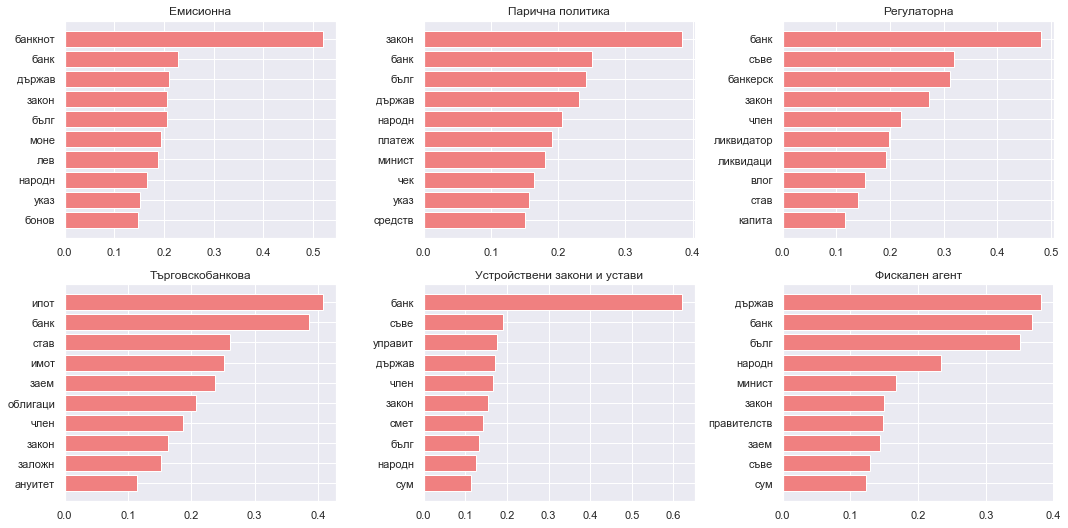

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))
for i in range(0, len(countsr)):
    df = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    words = df.index[:10]
    scores = df.iloc[:10,:].values[:,0]
    axes[int(i/3), i%3].barh(np.arange(len(words)), df.iloc[:10,:].values[:,0], align='center',
        color='lightcoral', ecolor='black');
    axes[int(i/3), i%3].set_yticks(np.arange(len(words)))
    axes[int(i/3), i%3].set_yticklabels(words)
    axes[int(i/3), i%3].invert_yaxis()  # labels read top-to-bottom
    axes[int(i/3), i%3].set_title(countsr['Function'][i])

fig.tight_layout()

In [13]:
countsr = db.groupby(['Ruler'], as_index=False)['Text'].agg({'Text': ' '.join})
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(countsr['Text'])

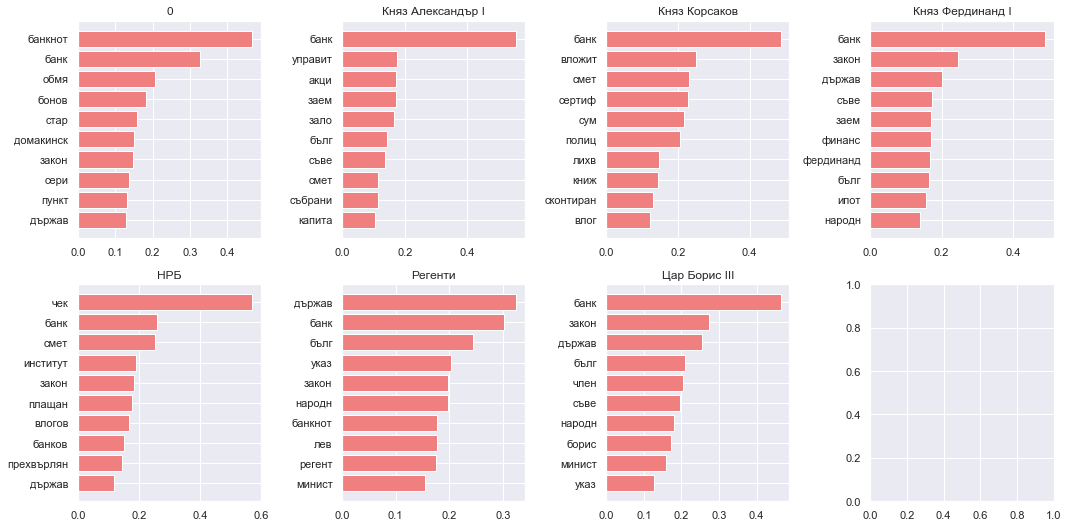

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
for i in range(0, len(countsr)):
    df = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    words = df.index[:10]
    scores = df.iloc[:10,:].values[:,0]
    axes[int(i/4), i%4].barh(np.arange(len(words)), df.iloc[:10,:].values[:,0], align='center',
        color='lightcoral', ecolor='black');
    axes[int(i/4), i%4].set_yticks(np.arange(len(words)))
    axes[int(i/4), i%4].set_yticklabels(words)
    axes[int(i/4), i%4].invert_yaxis()  # labels read top-to-bottom
    axes[int(i/4), i%4].set_title(countsr['Ruler'][i])

fig.tight_layout()

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
count_vectorizer = CountVectorizer()
vectorizer = count_vectorizer.fit(db['Text'])
count_data = vectorizer.transform(db['Text'])

In [16]:
##GRID SEARCH
# Define Search Param
ntopics = 6
search_params = {'n_components': [ntopics], 'learning_decay': [.05, .1, .2, .5, .7]}
lda = LDA()
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)
model.fit(count_data)
best_lda_model = model.best_estimator_
lda_output = best_lda_model.transform(count_data)

C:\Users\GerganaM\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


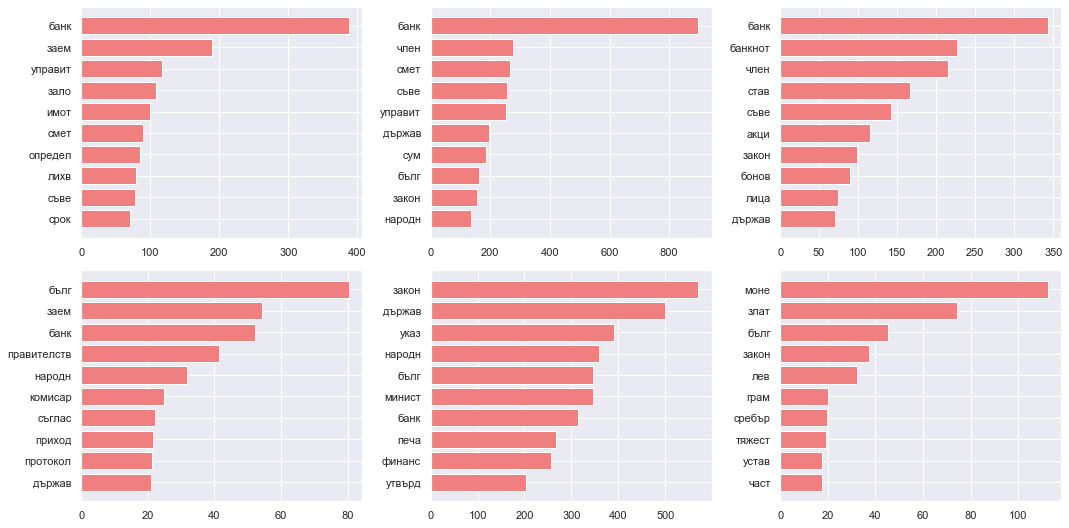

In [18]:
wordnames = np.array(vectorizer.get_feature_names())
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))
for i in range(0, 6):
    wordind = (-best_lda_model.components_[i]).argsort()[:10]
    scoresLDA = best_lda_model.components_[i][[wordind]]
    words = wordnames.take(wordind)
    axes[int(i/3), i%3].barh(np.arange(len(words)), scoresLDA, align='center',
        color='lightcoral', ecolor='black');
    axes[int(i/3), i%3].set_yticks(np.arange(len(words)))
    axes[int(i/3), i%3].set_yticklabels(words)
    axes[int(i/3), i%3].invert_yaxis()  
   

fig.tight_layout();